<a href="https://colab.research.google.com/github/MukRodrigues/Simulacao-difusao-reacao/blob/main/GITHUB_Simulacao_equacao_difusao_reacao_logistica_crank_nicolson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import exp, sin, pi, linalg

# Simulação Numérica


Vamos fazer a simulação da solução numérica da equação

\begin{cases}
\begin{eqnarray}
\partial _t \rho &=& \partial_x (D(x,t) \partial _x \rho) + r(t)\rho(x,t) \left(1 - \frac{\rho(x,t)}{K(t)}\right) \\
\rho(0,t) &=& \rho(L,t) = 0 \\
\rho(x,0) &=&  \frac{N_0}{b-a}\chi _{[a,b]}, \quad  \hskip2.4cm x \in [a,b] \subset (0, L)
\end{eqnarray}
\end{cases}

com $(x,t) \in [0,L] \times \mathbb{R}_+$, $L>0$, e $N_0$ correspondendo ao tamanho inicial da população.

**Difusão variável com crecimento logístico**

A discretização da EDP com o método de Crank-Nilson fica

\begin{eqnarray}
 (-\gamma_1 E ^{j+1/2}_{i} - \gamma_2 D^{j+1/2}_{i}) \rho^{j+1}_{i+1} + (1 + 2 \gamma_2 D^{j+1/2}_{i}) \rho^{j+1}_{i} + (\gamma_1 E ^{j+1/2}_{i} - \gamma_2 D^{j+1/2}_{i}) \rho^{j+1}_{i-1} = (\gamma_1 E ^{j+1/2}_{i} + \gamma_2 D^{j+1/2}_{i})\rho^{j}_{i+1} +(r^{j+1/2}- 2 \gamma_2 D^{j+1/2}_{i}) \rho^{j}_{i} + (-\gamma_1 E ^{j+1/2}_{i} + \gamma_2 D^{j+1/2}_{i}) \rho^{j}_{i-1} + k\ r^{j+1/2}_{i}\rho^{j}_{i} \left( 1 - \frac{ \rho^{j} _{i} }{ K^{j+1/2}_{i}} \right).
\end{eqnarray}

 com $h=\Delta x$, $k=\Delta t$, $\gamma_1 = k / 4h$ e $\gamma_2 = k / 2h^2$.

In [2]:
# parâmetros
L = 5
T = 20
k = 0.02  #quanto menor, maior o tempo de processamento!
h = 0.005
gamma1 = k/(4*h)
gamma2 = k/(2*h**2)

# Malha
x = np.arange(0,L+h,h)   #dessa forma, adaptando os steps, dá pra definir qualquer intervalo em x
x0 = (min(x) + max(x))/2
t = np.arange(0,T+k,k)
n = len(x)
m = len(t)

[m,n]

[1001, 1001]

#### Funções auxiliares

In [3]:
#funções auxiliares

#suporte
k1 = 5
k2 = 0.1*k1
pk = T/2.5
K = k1 + k2*sin(2*pi*t/pk) + k/2

#tx crescimento
r1 = 1.5
r2 = 0.3*r1
pr = T/10 #periodo oscilação crescimento
r = r1 + r2*sin(2*pi*t/pr) + k/2

# Difusividade D(x,t) e sua derivada Dx
D0 = 0.5
D = np.zeros((n,m))
Dx = np.zeros((n,m))
for i in range(n):
  for j in range(m):
      D[i,j] = D0 * (exp(-K[j]*(x0 - x[i])**2 )) + k/2 #difusao
      Dx[i,j] = (-2)*(K[j])*(-x0 + x[i])* D[i,j] + k/2   #convecção?? força a densidade a se mover na direção ao maior valor de x_i

#plt.plot(r)

##### Condições

In [4]:
# Condição Inicial
rhol = np.zeros((n, m))  # Matriz da densidade populacional
f_logi = np.zeros((n,m))

N0 = 15
dx=1
a = x0 - dx # início do suporte
b = x0 + dx # fim do suporte
rhol[:, 0] = np.where((x >= a) & (x <= b), N0 / (b - a)  , 0)   #N0/L

# Condição de contorno
boudaryconditions = [0,0]
rhol[0,:] = boudaryconditions[0]  # rho(0, t)
rhol[-1,:] = boudaryconditions[1] # rho(L, t)

#plt.plot(x,rho[:, 0])
#plt.show()

rho_kmax = k1+k2 +0*x
rho_kmin =  k1- k2 +0*x

##### Matrizes tridiagonais


 A forma matricial da solução fica

 $$
 A \rho^{j+1} = B  \rho^{j} + F(\rho^j).
 $$


In [5]:
#Construção das matrizes tridiagonais
A = np.zeros((n,m))
for i in range(n):
  #A = A + np.diag([1+2*gamma2*D[i,i]],0)
    A[i,i] = 1+2*gamma2*D[i,i]   #diag. principal
    if i < n-1:
      A[i,i+1] = -gamma1*Dx[i,i+1] - gamma2*D[i,i+1]      #diag. upper
      A[i+1,i] = gamma1*Dx[i+1,i] - gamma2*D[i+1,i]      #diag. lower


B = np.zeros((n,m))
for i in range(n):
  #A = A + np.diag([1+2*gamma2*D[i,i]],0)
    B[i,i] = 1-2*gamma2*D[i,i]   #diag. principal
    if i < n-1:
      B[i,i+1] = gamma1*Dx[i,i+1] + gamma2*D[i,i+1]      #diag. upper
      B[i+1,i] = -gamma1*Dx[i+1,i] + gamma2*D[i+1,i]      #diag. lower
      #print(r[i],-2*gamma2*D[i,i])


##### Sistema não-linear

In [6]:
# Resolver o sistema não linear "Ax=b + f" => A(x,t) * p(x,t+1) = B(x,t) * p(x,t) + f(x,t)
for j in range(0, m-1):
  b = rhol[:,j].copy()
  Logi = rhol[:,j].copy()* k*r[j] - rhol[:,j].copy()**2 * k*r[j]/K[j]
  b = np.dot(B,b) + Logi
  b[0] = boudaryconditions[0]
  b[-1] = boudaryconditions[-1]
  solution = linalg.solve(A,b)   #aqui se calcula p(x,t+1)
  rhol[:,j+1] = solution
  f_logi[:,j+1] = Logi   #incluir essa matriz para visualizar o que ocorre com a fonte durante o processo


### Gráficos

#### Densidade

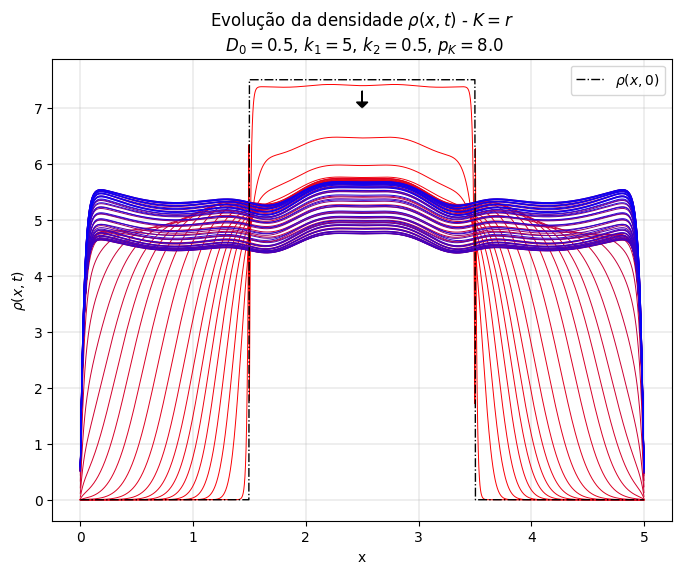

In [9]:
M = m
colors = [(1 - i/M, 0, i/M) for i in range(M)]
plt.figure(figsize=(8, 6))

for j in range(1, M, max(1, int(M/75))):
  plt.plot(x, rhol[:,j], linewidth=0.7, color=colors[j])

plt.plot(x, rhol[:, 0], label="$\\rho(x,0)$",linestyle='-.', linewidth=1,color='black')

plt.title(f'Evolução da densidade $\\rho(x,t)$ - $K=r$ \n $D_0=${D0}, $k_1 =${k1}, $k_2 =${k2}, $p_K=${round(pk,1)}')
plt.xlabel('x')
plt.ylabel('$\\rho(x,t)$')
#plt.xlim(0,1)
#plt.ylim(9.5,11)
plt.legend()
plt.grid(linestyle='-', linewidth=0.3)
plt.arrow(2.5,7.3,0,-0.2, head_width=0.1,head_length=0.1, color='black') #setinha
#plt.arrow(2.5,8.,0,0.2, head_width=-0.1,head_length=0.1, color='black') #setinha

#plt.savefig('difusao-_variavel_crescimento_logistico')  #para salvar a imagem
plt.show()
#print(f"Do tempo t={t[0]} até t={t[M].round(3)}.")

#### Massa

A massa populacional total em um modelo de difusão unidimensional é dada por:

$$
M(t) = \int_0^L \rho(x,t)\, dx = \frac{\Delta x}{2} (\rho^n _0 + 2\sum_{i=1} ^{N-2}  \rho^n _i  + \rho^n _{N-1} )  \ \ \ \  \text{(regra  dos trapézios composta)}
$$

onde $\rho(x,t)$ representa a densidade populacional no instante $t$ e posição $x \in [0, L]$.


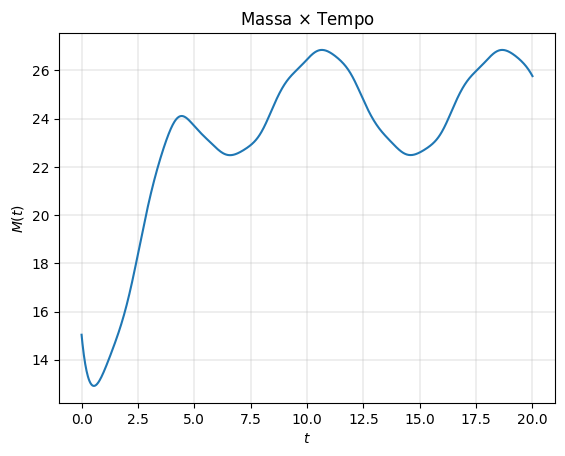

In [10]:
massa = []
for M in range(m):
  massa_parcial = h*0.5*(rhol[0,M]+ rhol[-1,M] )+ np.sum(rhol[1:-1,M] *h).round(5)
  massa.append(massa_parcial)

plt.plot(t, massa)
plt.title(f'Massa $\\times$ Tempo')
plt.xlabel('$t$')
plt.ylabel('$M(t)$')
plt.grid(linestyle='-', linewidth=0.3)


#plt.savefig('massa_crescimento_logistico') #para salvar a imagem
plt.show()